In [1]:
 # download datasets menggnakan widget
!wget --no-check-certificate \
  https://raw.githubusercontent.com/reski-mulud-muchamad/dataset/main/solar_angles_dataset.csv \
  -O solar_angles.csv

--2021-06-15 23:49:46--  https://raw.githubusercontent.com/reski-mulud-muchamad/dataset/main/solar_angles_dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8088656 (7.7M) [text/plain]
Saving to: ‘solar_angles.csv’

solar_angles.csv    100%[===================>]   7.71M  44.4MB/s    in 0.2s    

2021-06-15 23:49:47 (44.4 MB/s) - ‘solar_angles.csv’ saved [8088656/8088656]



In [2]:
# import library
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
 
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Conv1D

In [3]:
data_train = pd.read_csv('solar_angles.csv')
data_train.head()

,Unnamed: 0,Date (M/D/YYYY),Time (H:MM:SS),Topocentric zenith angle,Top. azimuth angle (eastward from N),Top. azimuth angle (westward from S),Julian day
0,0,1/1/2017,0:00:00,157.863107,308.657327,128.657327,2.457754e+06
1,1,1/1/2017,0:15:00,160.034217,316.136781,136.136781,2.457754e+06
2,2,1/1/2017,0:30:00,161.901608,325.052191,145.052191,2.457754e+06
3,3,1/1/2017,0:45:00,163.360197,335.548911,155.548911,2.457754e+06
4,4,1/1/2017,1:00:00,164.293788,347.499018,167.499018,2.457754e+06


In [4]:
data_train = data_train[['Date (M/D/YYYY)', 'Topocentric zenith angle']]
data_train.head()

,Date (M/D/YYYY),Topocentric zenith angle
0,1/1/2017,157.863107
1,1/1/2017,160.034217
2,1/1/2017,161.901608
3,1/1/2017,163.360197
4,1/1/2017,164.293788


In [5]:
data_train.isnull().sum()

Date (M/D/YYYY)             0
Topocentric zenith angle    0
dtype: int64

In [6]:
data_train

,Date (M/D/YYYY),Topocentric zenith angle
0,1/1/2017,157.863107
1,1/1/2017,160.034217
2,1/1/2017,161.901608
3,1/1/2017,163.360197
4,1/1/2017,164.293788
...,...,...
105211,1/1/2020,144.648900
105212,1/1/2020,147.463622
105213,1/1/2020,150.216607
105214,1/1/2020,152.884991


In [7]:
# hanya menggunakan 200000 data
# data_train = data_train[:20000]

In [8]:
dates = data_train['Date (M/D/YYYY)'].values
tza = data_train['Topocentric zenith angle'].values

In [9]:
min = tza.min()
max = tza.max()

# skala data
scale = max - min

# 10% dari skala data
ten_percent = scale * 0.1

# target mea untuk callback
target = ten_percent - 3.0

print('Skala data : ', scale)
print('Jumlah MEA harus kurang dari : ', ten_percent)
print('Target MEA : ', target)

Skala data :  150.026465
Jumlah MEA harus kurang dari :  15.0026465
Target MEA :  12.0026465


Text(0.5, 1.0, 'Solar Topocentric Zenith Angle')

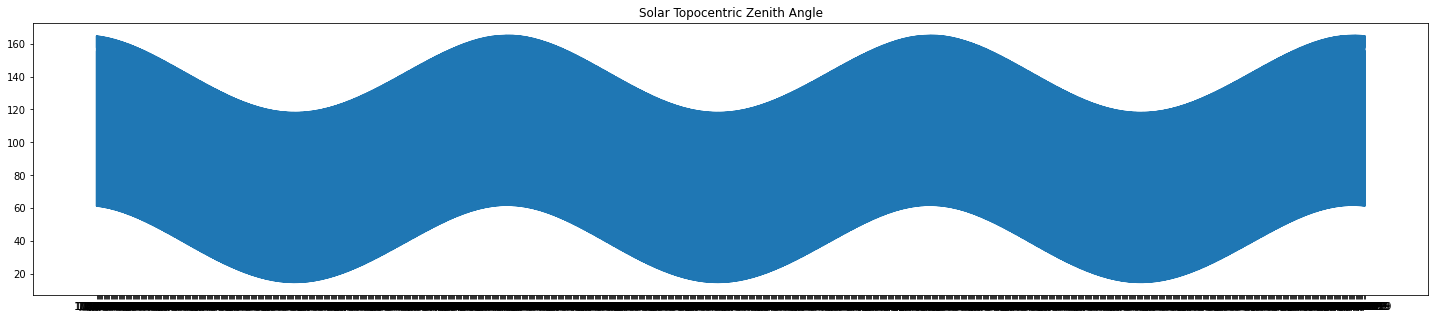

In [10]:
plt.figure(figsize=(25,5))
plt.plot(dates, tza)
plt.title('Solar Topocentric Zenith Angle')

In [11]:
# pembagian data train dan test
total = len(data_train)
train_size = total - int(total * 0.2)
test_size = total - train_size

print('Total data : %d data' % total)
print('Data train : %d data' % train_size)
print('Data test : %d data' % test_size)

Total data : 105216 data
Data train : 84173 data
Data test : 21043 data


In [12]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer) :
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True )
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

In [13]:
train_set = windowed_dataset(tza[:train_size], window_size=60, batch_size=256, shuffle_buffer=1000)
test_set = windowed_dataset(tza[:test_size], window_size=60, batch_size=256, shuffle_buffer=1000)

In [24]:
model = tf.keras.models.Sequential([Conv1D(60, 5, 1, 'causal', activation='relu', input_shape=[None, 1]),
                                    
                                    Bidirectional(LSTM(60, return_sequences=True)),
                                    Bidirectional(LSTM(60, return_sequences=True)),

                                    Dense(30, activation='relu'),
                                    Dense(30, activation='relu'),
                                    Dense(1)
                                    ])

In [25]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, None, 60)          360       
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 120)         58080     
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 120)         86880     
_________________________________________________________________
dense_3 (Dense)              (None, None, 30)          3630      
_________________________________________________________________
dense_4 (Dense)              (None, None, 30)          930       
_________________________________________________________________
dense_5 (Dense)              (None, None, 1)           31        
Total params: 149,911
Trainable params: 149,911
Non-trainable params: 0
________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [23]:
# callback
class myCallback(tf.keras.callbacks.Callback) :
  
  def on_epoch_end(self, epoch, logs={}) :
    if logs.get('mae') < target and logs.get('val_mae') < target :
      print('\nMAE sudah 10% dibawah skala data!')
      self.model.stop_training = True
 
callback = myCallback()

In [26]:
history = model.fit(train_set, 
                    epochs=100,
                    validation_data=test_set,
                    callbacks=callback)

Epoch 1/100
329/329 [==============================] - 168s 497ms/step - loss: 65.1361 - mae: 65.6349 - val_loss: 31.0272 - val_mae: 31.5245
Epoch 2/100
329/329 [==============================] - 154s 468ms/step - loss: 25.9332 - mae: 26.4298 - val_loss: 20.1925 - val_mae: 20.6884
Epoch 3/100
329/329 [==============================] - 155s 471ms/step - loss: 21.7398 - mae: 22.2349 - val_loss: 29.2865 - val_mae: 29.7828
Epoch 4/100
329/329 [==============================] - 154s 467ms/step - loss: 17.8784 - mae: 18.3712 - val_loss: 11.8291 - val_mae: 12.3191
Epoch 5/100
329/329 [==============================] - 154s 467ms/step - loss: 8.2999 - mae: 8.7814 - val_loss: 9.6872 - val_mae: 10.1640

MAE sudah 10% dibawah skala data!


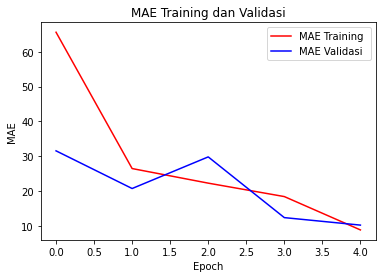

<Figure size 432x288 with 0 Axes>

In [27]:
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(mae))
 
plt.plot(epochs, mae, 'r', label='MAE Training ')                 
plt.plot(epochs, val_mae, 'b', label='MAE Validasi')
plt.title('MAE Training dan Validasi')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.figure()                                                                      
plt.show()

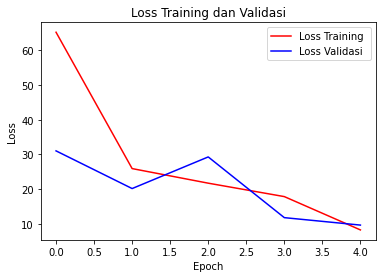

<Figure size 432x288 with 0 Axes>

In [28]:
epochs = range(len(loss))
 
plt.plot(epochs, loss, 'r', label='Loss Training ')                 
plt.plot(epochs, val_loss, 'b', label='Loss Validasi')
plt.title('Loss Training dan Validasi')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.figure()                                                                      
plt.show()